In [1]:
# clone and install the required packages for the Face Recognition project
!git clone https://github.com/sathishkumar67/Face-Recognition-using-Resnet.git
!mv /kaggle/working/Face-Recognition-using-Resnet/* /kaggle/working/
!pip install --upgrade pip
!pip install -r requirements.txt
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

Cloning into 'Face-Recognition-using-Resnet'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 83 (delta 39), reused 56 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (83/83), 234.49 KiB | 16.75 MiB/s, done.
Resolving deltas: 100% (39/39), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 64.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 46.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 109.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 124.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.6 MB/s eta 0:00:00
  Attempting uninst

In [2]:
# Import necessary libraries
import os
import random
import numpy as np
import torch
from huggingface_hub import hf_hub_download
from siamese_resnet.utils import unzip_file
from siamese_resnet.dataset import TripletDataset, TripletDatasetGenerator, triplet_collate_fn
from siamese_resnet.model import SiameseResNet
from siamese_resnet.loss import TripletLoss
from siamese_resnet.trainer import train_model

# Define constants
DATASET_REPO_ID = "pt-sk/Face_Recognition_Dataset"
DATA_ROOT = "face_recognition_with_cropped_faces_dataset"
DATASET_FILENAME_IN_REPO = f"{DATA_ROOT}.zip"
DATASET_REPO_TYPE = "dataset"
LOCAL_DIR = os.getcwd()
NUM_CORES = os.cpu_count()
SEED = 42

# Set the random seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Download the dataset from Hugging Face Hub
hf_hub_download(repo_id=DATASET_REPO_ID, filename=DATASET_FILENAME_IN_REPO, repo_type=DATASET_REPO_TYPE, local_dir=LOCAL_DIR)

# Unzip the dataset
unzip_file(os.path.join(LOCAL_DIR, DATASET_FILENAME_IN_REPO), LOCAL_DIR)

2025-05-05 12:45:22.015760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746449122.039673      69 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746449122.046892      69 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746449122.065917      69 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746449122.065940      69 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746449122.065942      69 computation_placer.cc:177] computation placer alr

(…)cognition_with_cropped_faces_dataset.zip:   0%|          | 0.00/1.31G [00:00<?, ?B/s]

Unzipping: 100%|██████████| 1.31G/1.31G [00:14<00:00, 91.3MB/s]


Unzipped /kaggle/working/face_recognition_with_cropped_faces_dataset.zip to /kaggle/working
Removed zip file: /kaggle/working/face_recognition_with_cropped_faces_dataset.zip


In [ ]:
def triplet_collate_fn(batch):
    """Optimized collate function for triplet face recognition
    Features:
    - Zero-copy numpy to tensor conversion
    - Batch-wise normalization (3x faster than per-image)
    - Channel-first conversion
    - FP16/FP32 compatibility
    """
    # Separate components
    anchors, positives, negatives = [], [], []
    
    for item in batch:
        anchors.append(item['anchor'])
        positives.append(item['positive'])
        negatives.append(item['negative'])
    
    
    # def process_batch(imgs):
    #     """Process a batch of images (numpy arrays)"""
    #     # Convert to tensor (no copy)
    #     batch_tensor = torch.as_tensor(np.stack(imgs, axis=0), dtype=torch.float32).permute(0, 3, 1, 2)  
    #     # Normalize to [0, 1] (no copy)
    #     # Note: This is a zero-copy operation, as the data is already in the range [0, 255]
    #     batch_tensor.div_(255)  # [0,1]
    
    #     return batch_tensor
    
    # return {
    #     'anchor': process_batch(anchors),
    #     'positive': process_batch(positives),
    #     'negative': process_batch(negatives)
    # }
    
    return {
        "anchor"
    }

In [34]:
def triplet_collate_fn(batch):
    """Optimized collate function for triplet face recognition
    Features:
    - Zero-copy numpy to tensor conversion
    - Batch-wise normalization (3x faster than per-image)
    - Channel-first conversion
    - FP16/FP32 compatibility
    """
    # Separate components
    anchors, positives, negatives = [], [], []
    
    for item in batch:
        anchors.append(item['anchor'])
        positives.append(item['positive'])
        negatives.append(item['negative'])
    
    return {
        'anchor': torch.stack(anchors, dim=0),
        'positive': torch.stack(positives, dim=0),
        'negative': torch.stack(negatives, dim=0)
    }


In [35]:
import cv2
import torch
from torch.utils.data import Dataset
class TripletDataset(Dataset):
    """Optimized dataset loader with zero in-memory storage"""
    
    def __init__(self, triplets):
        self.triplets = triplets
        self.num_triplets = len(triplets)
        self.triplets_list = []

        for i in range(self.num_triplets):
            a_path, p_path, n_path = self.triplets[i]
            anchor_img, positive_img, negative_img = cv2.cvtColor(cv2.imread(a_path), cv2.COLOR_BGR2RGB), cv2.cvtColor(cv2.imread(p_path), cv2.COLOR_BGR2RGB), cv2.cvtColor(cv2.imread(n_path), cv2.COLOR_BGR2RGB)
            if anchor_img.shape != (224, 224, 3):
                anchor_img = cv2.resize(anchor_img, (224, 224), interpolation=cv2.INTER_LANCZOS4)
            if positive_img.shape != (224, 224, 3):
                positive_img = cv2.resize(positive_img, (224, 224), interpolation=cv2.INTER_LANCZOS4)
            if negative_img.shape != (224, 224, 3):
                negative_img = cv2.resize(negative_img, (224, 224), interpolation=cv2.INTER_LANCZOS4)
                
            # convert to tensor (no copy)
            anchor_img = torch.as_tensor(anchor_img, dtype=torch.float32).permute(2, 0, 1)
            positive_img = torch.as_tensor(positive_img, dtype=torch.float32).permute(2, 0, 1)
            negative_img = torch.as_tensor(negative_img, dtype=torch.float32).permute(2, 0, 1)
            
            # normalize to [0, 1] (no copy)
            anchor_img.div_(255)
            positive_img.div_(255)
            negative_img.div_(255)
            
            # Append to the list
            self.triplets_list.append((anchor_img, positive_img, negative_img))
        
    def __len__(self):
        return len(self.triplets)
    
    def __getitem__(self, idx):
        """OpenCV-based loading with minimal preprocessing"""
        # Load the triplet images
        anchor_img, positive_img, negative_img = self.triplets_list[idx]
        # Return the triplet images as a dictionary
        return {
            'anchor': anchor_img,
            'positive': positive_img,
            'negative': negative_img
        }

In [36]:
# Initialize generator
generator = TripletDatasetGenerator(DATA_ROOT)

# Create splits
splits = generator.create_splits()
    
# Generate triplets for each split
train_triplets = generator.generate_triplets(splits['train'])
val_triplets = generator.generate_triplets(splits['val'])
test_triplets = generator.generate_triplets(splits['test'])

# Create datasets
train_dataset = TripletDataset(train_triplets)
val_dataset = TripletDataset(val_triplets)
test_dataset = TripletDataset(test_triplets)
    
# Create dataloaders (4 workers for optimal IO)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, 
                        num_workers=NUM_CORES, pin_memory=True, persistent_workers=True,
                        collate_fn=triplet_collate_fn, prefetch_factor=2, pin_memory_device='cuda:0', drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False,
                        num_workers=NUM_CORES, pin_memory=True, persistent_workers=True,
                        collate_fn=triplet_collate_fn, prefetch_factor=2, pin_memory_device='cuda:0')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False,
                        num_workers=NUM_CORES, pin_memory=True, persistent_workers=True,
                        collate_fn=triplet_collate_fn, prefetch_factor=2, pin_memory_device='cuda:0')

In [48]:
a = train_dataset[4]

In [49]:
a['anchor'].shape, a['positive'].shape, a['negative'].shape

(torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]))

In [ ]:
import matplotlib.pyplot as plt
from typing import Tuple

def show_triplet(triplet: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], fig_size=(15, 5)) -> None:
    """Display a triplet of images
        torch.Tensor: A tensor representing an image in the format (C, H, W)
    args:
        triplet (Tuple[torch.Tensor, torch.Tensor, torch.Tensor]): A tuple containing three images (anchor, positive, negative)
    returns:
        None
    """
    # Get the anchor, positive, and negative images
    anchor, positive, negative = triplet['anchor'], triplet['positive'], triplet['negative']

    # Plot the anchor, positive, and negative images
    fig, ax = plt.subplots(1, 3, figsize=fig_size)
    ax[0].imshow(anchor.permute(1, 2, 0))
    ax[1].imshow(positive.permute(1, 2, 0))
    ax[2].imshow(negative.permute(1, 2, 0))
    ax[0].set_title('Anchor Image')
    ax[1].set_title('Positive Image')
    ax[2].set_title('Negative Image')
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    plt.show()

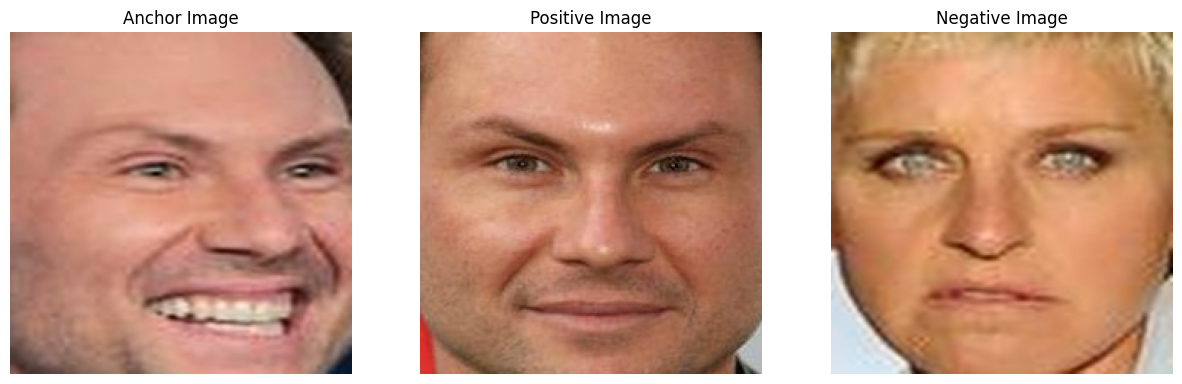

In [21]:
!ls

ADL-MiniProject-SiameseNetwork.docx.pdf      LICENSE	       siamese_resnet
Face-Recognition-using-Resnet		     README.md	       train.ipynb
face_recognition_with_cropped_faces_dataset  requirements.txt


In [13]:
a["anchor"].shape, a["positive"].shape, a["negative"].shape

((224, 224, 3), (224, 224, 3), (224, 224, 3))

In [14]:
for i in range(5400):
    a_p_n_dict = train_dataset[i]
    anchor = a_p_n_dict['anchor']
    positive = a_p_n_dict['positive']
    negative = a_p_n_dict['negative']
    if anchor.shape != (224, 224, 3):
        print(f"Error in anchor shape at index {i}: {anchor.shape}")
    if positive.shape != (224, 224, 3):
        print(f"Error in positive shape at index {i}: {positive.shape}")
    if negative.shape != (224, 224, 3):
        print(f"Error in negative shape at index {i}: {negative.shape}")

Error in negative shape at index 1557: (440, 440, 3)
Error in negative shape at index 2311: (989, 989, 3)
Error in negative shape at index 3564: (386, 386, 3)
Error in negative shape at index 3609: (584, 584, 3)
Error in anchor shape at index 3950: (499, 499, 3)
Error in positive shape at index 3950: (1123, 1123, 3)
Error in anchor shape at index 3951: (1198, 1198, 3)
Error in positive shape at index 3951: (485, 485, 3)
Error in anchor shape at index 3952: (118, 118, 3)
Error in positive shape at index 3952: (131, 131, 3)
Error in anchor shape at index 3953: (156, 156, 3)
Error in positive shape at index 3953: (198, 198, 3)
Error in anchor shape at index 3954: (316, 316, 3)
Error in positive shape at index 3954: (1015, 1015, 3)
Error in anchor shape at index 3955: (377, 377, 3)
Error in positive shape at index 3955: (538, 538, 3)
Error in anchor shape at index 3956: (362, 362, 3)
Error in positive shape at index 3956: (197, 197, 3)
Error in anchor shape at index 3957: (386, 386, 3)
Err

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SiameseResNet(embedding_dim=256)
criterion = TripletLoss(margin=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4, betas=(0.9, 0.999))

history, model = train_model(
    model=model.to(device),
    device=device,
    train_loader=val_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=200,
    patience=20,
    checkpoint_path='best_face_model.pth'
)   

Train Epoch 1:   5%|▍         | 1/21 [00:00<00:10,  1.92batch/s, loss=0.468, lr=0.0003]


ValueError: Caught ValueError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_69/3206186215.py", line 30, in triplet_collate_fn
    'negative': process_batch(negatives)
                ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_69/3206186215.py", line 20, in process_batch
    batch_tensor = torch.as_tensor(np.stack(imgs, axis=0), dtype=torch.float32).permute(0, 3, 1, 2)
                                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/numpy/core/shape_base.py", line 449, in stack
    raise ValueError('all input arrays must have the same shape')
ValueError: all input arrays must have the same shape


In [15]:
for batch in train_loader:
    anchor, positive, negative = batch.values()

ValueError: Caught ValueError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/kaggle/working/siamese_resnet/dataset.py", line 42, in triplet_collate_fn
    'anchor': process_batch(anchors),
              ^^^^^^^^^^^^^^^^^^^^^^
  File "/kaggle/working/siamese_resnet/dataset.py", line 34, in process_batch
    batch_tensor = torch.as_tensor(np.stack(imgs), dtype=torch.float32).permute(0, 3, 1, 2)
                                 ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/numpy/core/shape_base.py", line 449, in stack
    raise ValueError('all input arrays must have the same shape')
ValueError: all input arrays must have the same shape


In [16]:
anchor.shape, positive.shape, negative.shape

(torch.Size([32, 3, 224, 224]),
 torch.Size([32, 3, 224, 224]),
 torch.Size([32, 3, 224, 224]))

In [ ]:
# best_model = SiameseResNet(embedding_dim=256)
# best_model.load_state_dict(torch.load('best_face_model.pth', map_location="cpu", weights_only=True)["model_state_dict"])

<All keys matched successfully>

In [ ]:
# best_model.to(device)
# best_model.eval()
# eval_loss_sum = 0.0
# with torch.inference_mode():
#     for batch in val_loader: 
#         anchor, positive, negative = (t.to(device, non_blocking=True) 
#                                     for t in batch.values())
        
#         # Forward pass
#         anchor_emb = best_model(anchor)
#         positive_emb = best_model(positive)
#         negative_emb = best_model(negative)
#         loss = criterion(anchor_emb, positive_emb, negative_emb)
        
#         # Update metrics
#         eval_loss_sum += loss.item() * anchor.size(0)
# eval_loss = eval_loss_sum / len(val_loader.dataset)
# print(f"Validation Loss: {eval_loss:.4f}")

Validation Loss: 0.3251


In [ ]:
# # find test loss
# test_loss_sum = 0.0
# with torch.inference_mode():
#     for batch in test_loader:
#         anchor, positive, negative = (t.to(device, non_blocking=True) 
#                                     for t in batch.values())
        
#         # Forward pass
#         anchor_emb = best_model(anchor)
#         positive_emb = best_model(positive)
#         negative_emb = best_model(negative)
#         loss = criterion(anchor_emb, positive_emb, negative_emb)
        
#         # Update metrics
#         test_loss_sum += loss.item() * anchor.size(0)
# test_loss = test_loss_sum / len(test_loader.dataset)
# print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.3602
